# Извлечение MFCC-признаков

In [1]:
from pathlib import Path
from kaldi.feat.mfcc import Mfcc, MfccOptions
from kaldi.matrix import SubVector, SubMatrix
from kaldi.util.options import ParseOptions
from kaldi.util.table import SequentialWaveReader
from kaldi.util.table import MatrixWriter
from numpy import mean
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import seaborn as sns

## Определение параметров

In [2]:
SCP_PATH = 'data/example.scp'
ARK_PATH = 'data/example_mfcc.ark'

In [3]:
po = ParseOptions("Извлечение MFCC-признаков")
po.register_float('min-duration', 0.0, 'Минимальная длительность сегмента')
mfcc_opts = MfccOptions()
mfcc_opts.frame_opts.samp_freq = 8000
mfcc_opts.register(po)
opts = po.parse_args()

## Выполнение извлечения MFCC-признаков

In [4]:
mfcc = Mfcc(mfcc_opts)
sf = mfcc_opts.frame_opts.samp_freq

In [5]:
rspec, wspec = "scp:" + SCP_PATH, "ark,t:" + ARK_PATH

Канал 0
Частота дискретизации: 8000.0
Матрица признаков:

    0     0     0  ...      0     0     0
[kaldi.matrix._matrix.Matrix of size 1x126008]

Субматрица признаков:

 5.6521e-01 -5.2602e-01 -1.2770e-01  ...   1.1277e-01  1.0332e-01 -6.5425e-01
 8.6402e-01 -6.2894e-01 -1.3865e-01  ...   1.5043e-01  1.3188e+00 -9.4396e-02
 1.2076e+00 -4.3645e-01 -8.7183e-01  ...   6.0254e-02 -1.1249e-01 -2.5726e-01
                ...                   ⋱                   ...                
 1.8514e+00 -1.2324e+00 -1.6545e+00  ...  -1.1276e+00  1.0460e-01 -6.5611e-01
-5.9223e-01 -3.3410e-01 -2.9735e-01  ...   8.4621e-01  1.3739e+00 -8.2190e-01
-5.9101e-01 -4.5198e-01 -7.8238e-01  ...   9.6148e-01 -7.6494e-01  1.8573e+00
[kaldi.matrix._matrix.SubMatrix of size 1573x13]


Канал 1
Частота дискретизации: 8000.0
Матрица признаков:

    0     0     0  ...     -8    -5     5
[kaldi.matrix._matrix.Matrix of size 1x126008]

Субматрица признаков:

-3.8469e+00 -1.8386e+00 -4.5824e-01  ...   4.7097e-01  1.6665

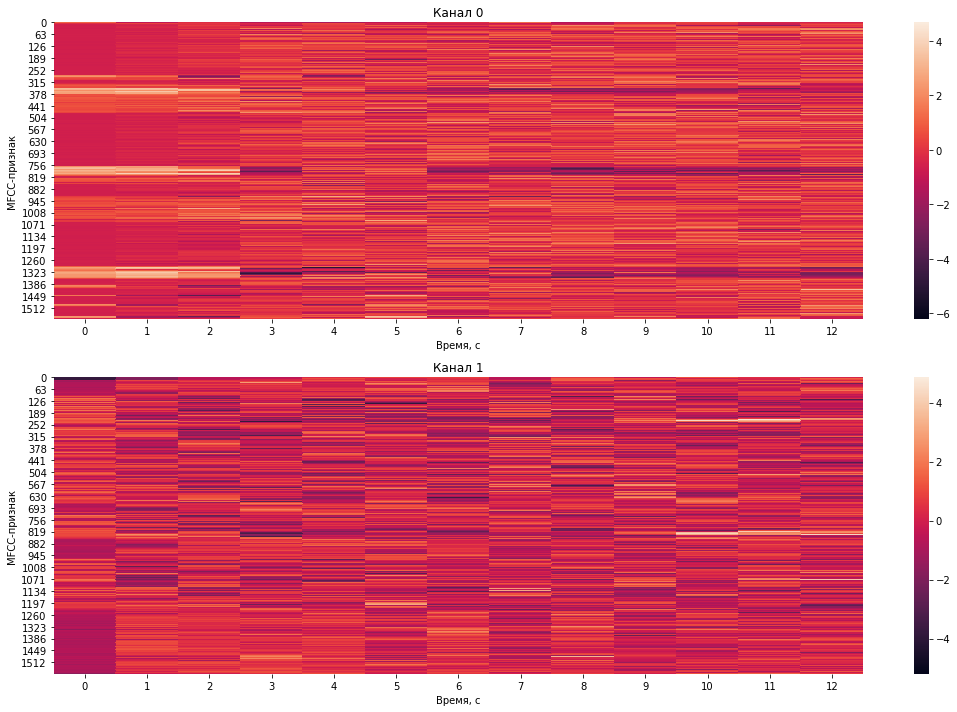

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

with SequentialWaveReader(rspec) as reader, \
             MatrixWriter(wspec) as writer:
            
    for i, (key, wav) in enumerate(reader):
        if wav.duration < opts.min_duration:
            continue
                    
        assert(wav.samp_freq >= sf)
        assert(wav.samp_freq % sf == 0)
        
        print("Канал {}".format(i))
        print("Частота дискретизации: {}".format(wav.samp_freq))
        
        s = wav.data()
        print("Матрица признаков:")
        print(s)
        
        # Даунсэмплинг
        s = s[:, ::int(wav.samp_freq / sf)]

        # Перевод в моно
        m = SubVector(mean(s, axis=0))

        # Вычисление MFCC-признаков
        f = mfcc.compute_features(m, sf, 1.0)

        # Стандартизация признаков
        f = SubMatrix(scale(f))
        print("Субматрица признаков:")
        print(f)
        print()

        # Запись признаков в архив
        writer[key] = f
        
        sns.heatmap(f, ax=axes[i])
        axes[i].set_title("Канал {}".format(i))
        axes[i].set_xlabel("Время, с")
        axes[i].set_ylabel("MFCC-признак")

plt.tight_layout()